<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/ImageGeneration/code/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.tensorboard import SummaryWriter
import datetime
import os

# 장치

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data

In [5]:
transformer = transforms.Compose([transforms.ToTensor()])

In [6]:
train_data = torchvision.datasets.MNIST(root='./',train=True,download=True,transform = transformer)
test_data = torchvision.datasets.MNIST(root='./',train=False,download=True,transform = transformer)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
from torch.utils.data import DataLoader  
train_loader = DataLoader(train_data, batch_size=256,shuffle=True,num_workers=2)
test_loader = DataLoader(test_data,batch_size=256,num_workers=2)

In [8]:
# data check
sample, label = next(iter(train_loader))

def imshow_grid(img):
  img = torchvision.utils.make_grid(img)
  print(img.shape)
  plt.imshow(img.permute(1,2,0))
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  plt.show()

torch.Size([3, 32, 242])


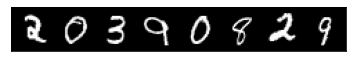

In [9]:
imshow_grid(sample[:8])

# 모형

In [11]:
class VAE(nn.Module):
  def __init__(self, image_size, hidden_size_1,hidden_size_2,latent_size):
    super(VAE,self).__init__()

    self.fc1 = nn.Linear(image_size,hidden_size_1) 
    self.fc2 = nn.Linear(hidden_size_1,hidden_size_2)
    self.fc31 = nn.Linear(hidden_size_2,latent_size) # 평균
    self.fc32 = nn.Linear(hidden_size_2,latent_size) # 분산

    self.fc4 = nn.Linear(latent_size,hidden_size_2)
    self.fc5 = nn.Linear(hidden_size_2,hidden_size_1)
    self.fc6 = nn.Linear(hidden_size_1,image_size)

  # Image를 받아서 평균과 분산 출력
  def encode(self,x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    return self.fc31(h2), self.fc32(h2)

  # Latent variable z 
  def reparameterize(slef,mu,logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std) #입력과 동일한 모양으로 평균이 0이고 분산이 1인 정규분포에서 숫자를 뽑아 tensor 생성
    return mu + std * eps #논문에서 나온 식

  def decode(self,z):
    h3 = F.relu(self.fc4(z))
    h4 = F.relu(self.fc5(h3))
    return torch.sigmoid(self.fc6(h4))

  def forward(self,x):
    mu, logvar = self.encode(x.view(-1,784))
    z = self.reparameterize(mu, logvar)
    return self.decode(z),mu,logvar

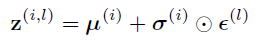

In [12]:
model = VAE(28*28,512,256,2).to(device)

In [13]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [14]:
optimizer = optim.Adam(model.parameters(),lr=1e-3)

# 손실함수

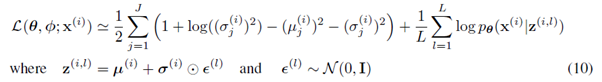

In [15]:
def loss_function(recon_x,x,mu,logvar):
  BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE, KLD

# 학습

In [16]:
def train(epoch, model, train_loader, optimizer):
  model.train()
  train_loss = 0
  for batch, (data,_) in enumerate(train_loader): 
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch,mu,logvar = model(data)
    BCE,KLD = loss_function(recon_batch,data,mu,logvar)
    loss = BCE+KLD

    loss.backward()

    train_loss += loss.item()
    optimizer.step()

    if batch% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader),
                loss.item() / len(data)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)
    ))     

In [17]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            
            recon_batch, mu, logvar = model(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)

            loss = BCE + KLD

            test_loss += loss.item()

            if batch_idx == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(256, 1, 28, 28)[:n]]) # (16, 1, 28, 28)
                grid = torchvision.utils.make_grid(comparison.cpu()) # (3, 62, 242)

In [20]:
def latent_to_image(epoch, model):
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device)
        recon_image = model.decode(sample).cpu()
        grid = torchvision.utils.make_grid(recon_image.view(64, 1, 28, 28))

In [22]:
for epoch in tqdm(range(50)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
======> Epoch: 29 Average loss: 23.1810
======> Epoch: 29 Average loss: 23.7452
======> Epoch: 29 Average loss: 24.3205
======> Epoch: 29 Average loss: 24.8944
======> Epoch: 29 Average loss: 25.4623
======> Epoch: 29 Average loss: 26.0622
======> Epoch: 29 Average loss: 26.6416
======> Epoch: 29 Average loss: 27.1947
======> Epoch: 29 Average loss: 27.7628
======> Epoch: 29 Average loss: 28.3501
======> Epoch: 29 Average loss: 28.9370
======> Epoch: 29 Average loss: 29.5035
======> Epoch: 29 Average loss: 30.0674
======> Epoch: 29 Average loss: 30.6241
======> Epoch: 29 Average loss: 31.2087
======> Epoch: 29 Average loss: 31.7935
======> Epoch: 29 Average loss: 32.3724
======> Epoch: 29 Average loss: 32.9479
======> Epoch: 29 Average loss: 33.5277
======> Epoch: 29 Average loss: 34.1147
======> Epoch: 29 Average loss: 34.6776
======> Epoch: 29 Average loss: 35.2496
======> Epoch: 29 Average loss: 35.8153
======> Epoch: 29 Average loss: 36.4115
====

In [24]:
with torch.no_grad():
      sample = torch.randn(64, 2).to(device)
      recon_image = model.decode(sample).cpu()
      grid = torchvision.utils.make_grid(recon_image.view(64, 1, 28, 28))

torch.Size([3, 242, 242])


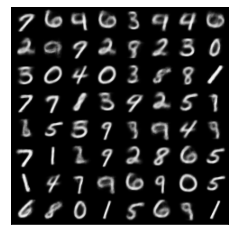

In [28]:
imshow_grid(grid)